In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Download Tiny_Imagenet dataset

In [2]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

fatal: destination path 'IMagenet' already exists and is not an empty directory.
test  train  val  wnids.txt  words.txt


We'll need to update our path to import from Drive.

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/EVA4/S12/')


In [0]:
#!unzip tiny-imagenet-200.zip

## PREPERATION OF DATA SET. 


### SPLIT INTO TRAIN AND TEST DATA SETS

In [4]:
import os
from dataset.dataset_utils import create_and_split_dataset, find_classes
import dataset.dataset_utils as data_utils
import importlib
importlib.reload(data_utils)

dir = 'IMagenet/tiny-imagenet-200/train'


classes, class_to_idx = find_classes(dir)
print("Number of classes : ", len(classes))

test_ratio = 30
train_file_names, test_file_names, train_classname_dict, test_classname_dict, classes_dict = create_and_split_dataset(dir, class_to_idx, test_ratio)

Number of classes :  200
Total Image Count =  100000
Train Image Count =  70000
Test  Image Count =  30000


## Find Mean and STD

In [5]:
import torch
from dataset.ImagenetDataset import ImagenetDataset

train_data = ImagenetDataset(dir,train_file_names, train_classname_dict,classes_dict)
test_data = ImagenetDataset(dir,test_file_names,test_classname_dict,classes_dict)


69999
29999


## Now we can import the custom model library and other functions

In [6]:
img, cls =train_data[69999]
print(img.shape,cls)

torch.Size([3, 64, 64]) 199


In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations.pytorch import ToTensor
from models import Resnet18 as resnet18
from transformations import ImagenetTiny_Alb as imnet

from utils.global_fun import show_summary, run_model_with_entropy,  draw_accuracy_loss_change_graps, plot_accuracy_loss_graphs

import importlib
importlib.reload(resnet18)
importlib.reload(imnet)

use_cuda = torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
CUDA_LAUNCH_BLOCKING=1
SEED = 1
# CUDA?
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

imagenet_num_classes = 200
model = resnet18.ResNet18(imagenet_num_classes).to(device)


if use_cuda:
    torch.cuda.manual_seed(SEED)
    model = torch.nn.DataParallel(model)





criterion = torch.nn.CrossEntropyLoss()
imagenet_model = imnet.Imagenet_Alb(model,train_data,test_data,criterion,None,None)


show_summary(imagenet_model,input_size=(3,64,64))

cuda
CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNo

# Implement custom model with One-Cycle LR

##SHOW PARAMETERS

## **LRFinder** - Range test ( Accuracy v/s LR)

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()
Max Accuracy = 1.8 at LR = 0.18334049650160736


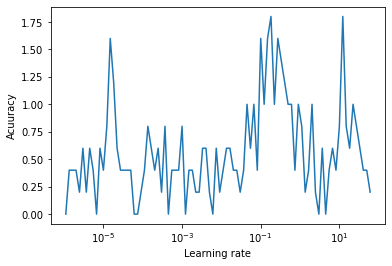

In [7]:

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#from torchvision.datasets import CIFAR10
from lr_finder import LRFinder as lrfinder
import dataset.ImagenetDataset as imdataset

#criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(imagenet_model.m_model.parameters(), lr=1e-7)
lr_finder = lrfinder.LRFinder(imagenet_model.m_model, optimizer, criterion, device="cuda")
lr_finder.range_test(imagenet_model.m_train_loader, end_lr=50, num_iter=100, step_mode="exp")
lr_finder.plot(skip_end=0, accuracy_flag = True)
lr_finder.reset()


# One Cycle LR

In [0]:

from utils.global_fun import test_model
from utils.global_fun import train_model
from utils.global_fun import show_summary, run_model_with_entropy_A11,  draw_accuracy_loss_change_graps, plot_accuracy_loss_graphs

import utils.global_fun as fun
from models import Resnet18 as resnet18
from transformations import ImagenetTiny_Alb as imnet
#import OneCycleLR_A11 as oneCycle 
from CyclicLR import OneCycleLR as oneCycle

#from torch.optim.lr_scheduler import OneCycleLR
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(imagenet_model.m_model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-04)


lr_max = 0.5
lr_min = lr_max / 100
epochs     = 40
batch_size = 500
iterations = (epochs*70000)/batch_size

# scheduler = oneCycle.OneCycleLR_A11(optimizer, batch_size, 30, (lr_min, lr_max), (0.85, 0.95))
scheduler = oneCycle.OneCycleLR(optimizer, iterations, lr_range = (lr_min, lr_max), momentum_range =(0.85, 0.95), annihilation_frac = 0.4, reduce_factor =0.01)

imagenet_model.setOptimizer(optimizer)
imagenet_model.setScheduler(scheduler)


RUNNING WITH REGULARIZATION

In [0]:

run_model_with_entropy_A11(imagenet_model, device, doL1= 0, doL2=0, LAMBDA=0, EPOCHS=epochs)

  0%|          | 0/140 [00:00<?, ?it/s]

EPOCH: 0

OneCyclicLR:  steps: 0/5600.0, LR: 0.0050, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 0


  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 1492/30000 (4.97%)

EPOCH: 1

OneCyclicLR:  steps: 140/5600.0, LR: 0.0462, Momentum: 0.9417%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 1


Loss=3.74233078956604 Batch_id=139 Accuracy=13.22: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 2854/30000 (9.51%)

EPOCH: 2

OneCyclicLR:  steps: 280/5600.0, LR: 0.0875, Momentum: 0.9333%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 2


Loss=3.4158616065979004 Batch_id=139 Accuracy=20.25: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 4529/30000 (15.10%)

EPOCH: 3

OneCyclicLR:  steps: 420/5600.0, LR: 0.1288, Momentum: 0.9250%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 3


Loss=3.0362112522125244 Batch_id=139 Accuracy=25.78: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 5431/30000 (18.10%)

EPOCH: 4

OneCyclicLR:  steps: 560/5600.0, LR: 0.1700, Momentum: 0.9167%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 4


Loss=2.811443567276001 Batch_id=139 Accuracy=30.30: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6541/30000 (21.80%)

EPOCH: 5

OneCyclicLR:  steps: 700/5600.0, LR: 0.2113, Momentum: 0.9083%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 5


Loss=2.6081855297088623 Batch_id=139 Accuracy=34.35: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6884/30000 (22.95%)

EPOCH: 6

OneCyclicLR:  steps: 840/5600.0, LR: 0.2525, Momentum: 0.9000%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 6


Loss=2.610901355743408 Batch_id=139 Accuracy=38.19: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8329/30000 (27.76%)

EPOCH: 7

OneCyclicLR:  steps: 980/5600.0, LR: 0.2938, Momentum: 0.8917%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 7


Loss=2.3639848232269287 Batch_id=139 Accuracy=40.99: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 9623/30000 (32.08%)

EPOCH: 8

OneCyclicLR:  steps: 1120/5600.0, LR: 0.3350, Momentum: 0.8833%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 8


Loss=2.287080764770508 Batch_id=139 Accuracy=43.99: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 9042/30000 (30.14%)

EPOCH: 9

OneCyclicLR:  steps: 1260/5600.0, LR: 0.3762, Momentum: 0.8750%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 9


Loss=2.2435266971588135 Batch_id=139 Accuracy=46.50: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 7637/30000 (25.46%)

EPOCH: 10

OneCyclicLR:  steps: 1400/5600.0, LR: 0.4175, Momentum: 0.8667%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 10


Loss=1.9844880104064941 Batch_id=139 Accuracy=48.60: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8391/30000 (27.97%)

EPOCH: 11

OneCyclicLR:  steps: 1540/5600.0, LR: 0.4587, Momentum: 0.8583%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 11


Loss=2.107292890548706 Batch_id=139 Accuracy=50.54: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 7478/30000 (24.93%)

EPOCH: 12

OneCyclicLR:  steps: 1680/5600.0, LR: 0.5000, Momentum: 0.8500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 12


Loss=1.9587336778640747 Batch_id=139 Accuracy=53.18: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 10126/30000 (33.75%)

EPOCH: 13

OneCyclicLR:  steps: 1820/5600.0, LR: 0.4587, Momentum: 0.8583%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 13


Loss=1.847637414932251 Batch_id=139 Accuracy=56.09: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 10285/30000 (34.28%)

EPOCH: 14

OneCyclicLR:  steps: 1960/5600.0, LR: 0.4175, Momentum: 0.8667%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 14


Loss=1.8329542875289917 Batch_id=139 Accuracy=58.77: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8440/30000 (28.13%)

EPOCH: 15

OneCyclicLR:  steps: 2100/5600.0, LR: 0.3762, Momentum: 0.8750%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 15


Loss=1.5265493392944336 Batch_id=139 Accuracy=62.29: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 10443/30000 (34.81%)

EPOCH: 16

OneCyclicLR:  steps: 2240/5600.0, LR: 0.3350, Momentum: 0.8833%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 16


Loss=1.5028259754180908 Batch_id=139 Accuracy=65.55: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 9870/30000 (32.90%)

EPOCH: 17

OneCyclicLR:  steps: 2380/5600.0, LR: 0.2937, Momentum: 0.8917%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 17


Loss=1.4399230480194092 Batch_id=139 Accuracy=69.67: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 10044/30000 (33.48%)

EPOCH: 18

OneCyclicLR:  steps: 2520/5600.0, LR: 0.2525, Momentum: 0.9000%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 18


Loss=1.1885607242584229 Batch_id=139 Accuracy=74.16: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 9429/30000 (31.43%)

EPOCH: 19

OneCyclicLR:  steps: 2660/5600.0, LR: 0.2112, Momentum: 0.9083%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 19


Loss=0.9469786882400513 Batch_id=139 Accuracy=79.90: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 9857/30000 (32.86%)

EPOCH: 20

OneCyclicLR:  steps: 2800/5600.0, LR: 0.1700, Momentum: 0.9167%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 20


Loss=0.5636019110679626 Batch_id=139 Accuracy=87.51: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 11224/30000 (37.41%)

EPOCH: 21

OneCyclicLR:  steps: 2940/5600.0, LR: 0.1288, Momentum: 0.9250%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 21


Loss=0.15939024090766907 Batch_id=139 Accuracy=95.98: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 13428/30000 (44.76%)

EPOCH: 22

OneCyclicLR:  steps: 3080/5600.0, LR: 0.0875, Momentum: 0.9333%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 22


Loss=0.035978369414806366 Batch_id=139 Accuracy=99.72: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 14968/30000 (49.89%)

EPOCH: 23

OneCyclicLR:  steps: 3220/5600.0, LR: 0.0463, Momentum: 0.9417%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 23


Loss=0.014981078915297985 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15218/30000 (50.73%)

EPOCH: 24

OneCyclicLR:  steps: 3360/5600.0, LR: 0.0050, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 24


Loss=0.013826075941324234 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15235/30000 (50.78%)

EPOCH: 25

OneCyclicLR:  steps: 3500/5600.0, LR: 0.0047, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 25


Loss=0.012254905886948109 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15231/30000 (50.77%)

EPOCH: 26

OneCyclicLR:  steps: 3640/5600.0, LR: 0.0044, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 26


Loss=0.013825569301843643 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15212/30000 (50.71%)

EPOCH: 27

OneCyclicLR:  steps: 3780/5600.0, LR: 0.0041, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 27


Loss=0.013547140173614025 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15184/30000 (50.61%)

EPOCH: 28

OneCyclicLR:  steps: 3920/5600.0, LR: 0.0038, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 28


Loss=0.014014684595167637 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15205/30000 (50.68%)

EPOCH: 29

OneCyclicLR:  steps: 4060/5600.0, LR: 0.0035, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 29


Loss=0.013523032888770103 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15190/30000 (50.63%)

EPOCH: 30

OneCyclicLR:  steps: 4200/5600.0, LR: 0.0031, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 30


Loss=0.013792243786156178 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15217/30000 (50.72%)

EPOCH: 31

OneCyclicLR:  steps: 4340/5600.0, LR: 0.0028, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 31


Loss=0.01295883022248745 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:02<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15194/30000 (50.65%)

EPOCH: 32

OneCyclicLR:  steps: 4480/5600.0, LR: 0.0025, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 32


Loss=0.01406504400074482 Batch_id=139 Accuracy=99.98: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 15203/30000 (50.68%)

EPOCH: 33

OneCyclicLR:  steps: 4620/5600.0, LR: 0.0022, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 33


Loss=0.014817197807133198 Batch_id=139 Accuracy=99.99: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 15191/30000 (50.64%)

EPOCH: 34

OneCyclicLR:  steps: 4760/5600.0, LR: 0.0019, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 34


Loss=0.014242975041270256 Batch_id=139 Accuracy=99.99: 100%|██████████| 140/140 [02:03<00:00,  1.14it/s]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 15208/30000 (50.69%)

EPOCH: 35

OneCyclicLR:  steps: 4900/5600.0, LR: 0.0016, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 35


Loss=0.014897361397743225 Batch_id=53 Accuracy=99.99:  39%|███▊      | 54/140 [00:47<01:15,  1.14it/s]

In [0]:
def ClassTestAccuracy(testloader,device,model):
  class_correct = list(0. for i in range(200))
  class_total = list(0. for i in range(200))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images =images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1

  for i in range(200):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
ClassTestAccuracy(imagenet_model.m_test_loader, device, imagenet_model.m_model)

Accuracy of n01443537 : 70 %
Accuracy of n01629819 : 72 %
Accuracy of n01641577 : 49 %
Accuracy of n01644900 : 30 %
Accuracy of n01698640 : 56 %
Accuracy of n01742172 : 37 %
Accuracy of n01768244 : 67 %
Accuracy of n01770393 : 28 %
Accuracy of n01774384 : 60 %
Accuracy of n01774750 : 45 %
Accuracy of n01784675 : 30 %
Accuracy of n01855672 : 44 %
Accuracy of n01882714 : 58 %
Accuracy of n01910747 : 72 %
Accuracy of n01917289 : 61 %
Accuracy of n01944390 : 32 %
Accuracy of n01945685 : 23 %
Accuracy of n01950731 : 53 %
Accuracy of n01983481 : 47 %
Accuracy of n01984695 : 50 %
Accuracy of n02002724 : 56 %
Accuracy of n02056570 : 62 %
Accuracy of n02058221 : 69 %
Accuracy of n02074367 : 81 %
Accuracy of n02085620 : 37 %
Accuracy of n02094433 : 50 %
Accuracy of n02099601 : 45 %
Accuracy of n02099712 : 23 %
Accuracy of n02106662 : 52 %
Accuracy of n02113799 : 21 %
Accuracy of n02123045 : 34 %
Accuracy of n02123394 : 62 %
Accuracy of n02124075 : 34 %
Accuracy of n02125311 : 38 %
Accuracy of n0

In [0]:
import random
import torch
from torch import nn
import torch.nn as nn
from torch.nn import functional as F
from torchvision.utils import save_image
from torchvision.models import densenet121, resnet18, resnet152, resnet101
from torchvision.transforms import functional as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from GradCAM import GradCAM


model = imagenet_model.m_model.to('cpu')
gradcam_object = GradCAM.GradCAM(model, model.layer2, classes)


print('incorrect samples collected for gradcam=',len(imagenet_model.m_incorrect_samples))
if(len(imagenet_model.m_incorrect_samples) > 1):
  images = [x for x in random.sample(imagenet_model.m_incorrect_samples, 10)]
  for img in images:
    print("####################################################################")
    im_      = img['image'].reshape(1,3,64,64).clone().detach()
    prediction = img["prediction"].item()
    label      = img["label"].item()
    print("Predicted value = ", classes[prediction])
    cam, heatmap, pred = gradcam_object.forward(im_, prediction, retain_graph= True)
    gradcam_object.visualiseGradcam(heatmap, im_)

    print("Actual Value    = ",classes[label])
    cam, heatmap, pred = gradcam_object.forward(im_, label, retain_graph= True)
    gradcam_object.visualiseGradcam(heatmap, im_)

    print("####################################################################")